In [1]:
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import Image
from lxml import objectify
import math
import time
from pytrends.request import TrendReq
from wordcloud import WordCloud
from ast import literal_eval
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_linear_regression
import numpy as np

#Import data from wikidata.org
from wikidata2df import wikidata2df

#Convert country name to ISO-3
import country_converter as coco

#World map plot librairies
import plotly.offline as po
import plotly.graph_objs as pg
import plotly.express as px
import plotly.graph_objs as go

# Analysis of the lexical fields
from empath import Empath 

#Warnings
import warnings

data_folder = './data/'

In [2]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_character_usa = pd.read_csv('df_character_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Principal_character_actor'])
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,beautiful,positive_emotion,negative_emotion,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,0.0,0.0,7.0,396.0,1.0,0.0,Ballard,Williams,F,Natasha Henstridge
7,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",NaN,...,0.0,8.0,5.0,1678.0,12.0,7.0,Mary,Banks,F,Julie Andrews
13,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",71%,...,0.0,4.0,9.0,730.0,11.0,4.0,Jody,Yvette,M,Tyrese Gibson
20,25960460,/m/0b6kc_5,Daddy and Them,2001,NaN,101.0,"{""/m/02h40lc"": ""English Language""}","['United States of America', 'Netherlands']","['Black comedy', 'Comedy']",86%,...,0.0,1.0,0.0,71.0,0.0,0.0,Claude,Montgomery,M,Billy Bob Thornton
25,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Action/Adventure', 'Action'...",0%,...,0.0,0.0,3.0,334.0,2.0,2.0,Crowe,NaN,F,Peggy Lipton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34388,26219108,/m/0b76gfr,The Leopard Woman,NaN,NaN,70.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Romance Film']",NaN,...,0.0,5.0,2.0,306.0,1.0,3.0,Culbertson,Chak,NaN,Shirley MacLaine
34389,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Comedy of manners', 'Dram...",72%,...,0.0,6.0,4.0,548.0,10.0,0.0,Akeem,Lisa,M,Eddie Murphy
34393,22330502,/m/05sync6,Inspiration,1931-01-31,NaN,74.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,0.0,2.0,0.0,164.0,2.0,0.0,Yvonne,Valbret,F,Greta Garbo
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,0.0,2.0,1.0,252.0,1.0,1.0,Carla,Walt,F,Julia Stiles


In [3]:
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()

In [4]:
merge = df_movie_usa.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
df_movie_usa = merge.drop(columns=['Principal_character_sex'])

In [5]:
#df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_movie_usa = df_movie_usa[(df_movie_usa.Actor_gender == 'M') | (df_movie_usa.Actor_gender == 'F')]
df_movie_usa = df_movie_usa.dropna(subset=['Movie_date'])
df_movie_usa = df_movie_usa.dropna(subset=['RT average_x'])
df_movie_usa['year'] = df_movie_usa['Movie_date'].apply(lambda x: int(x[0:4]))
df_movie_usa['TS score_x'] = df_movie_usa['TS score_x'].str.replace("\%", "", regex=True)
df_movie_usa['RT average_x'] = df_movie_usa['RT average_x'].str.split('/').str[0].astype(float)
df_movie_usa['TS score_x'] = df_movie_usa['TS score_x'].astype(float)
df_movie_usa.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [6]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['year']>=int(decade[0:4])) & (df_movie_usa['year']<int(decade[5:9]))].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]

In [7]:
df_movie_usa['gender'] = df_movie_usa['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [8]:
df_movie_group = df_movie_usa.groupby(['Decade'],group_keys = True).apply(lambda x:x)
df_movie_group.index = df_movie_group.index.droplevel(1)
df_movie_group.rename_axis(None, axis=1).rename_axis('id', axis=0)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TSscore,...,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_actor,Actor_name,Actor_gender,year,Decade,gender
id,,,,,,,,,,,,,,,,,,,,,
1,3333,/m/0151l,The Birth of a Nation,1915,50000000.0,190.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Indie', 'Costume drama', 'Epi...",93.0,...,8.0,7.0,Cameron,Elsie,Bette Davis,Bette Davis,F,1915,1,0
1,73380,/m/0jq5p,Broken Blossoms,1919,NaN,75.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Silent film', 'Indie', 'Black-and-white', 'D...",95.0,...,3.0,0.0,Cheng,Lucy,Olivia de Havilland,Olivia de Havilland,F,1919,1,0
1,238484,/m/01jlds,Tillie's Punctured Romance,1914-11-14,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Silent film', 'Indie', 'B...",90.0,...,6.0,6.0,Tillie,Chaplin,Chris Bruno,Chris Bruno,M,1914,1,1
2,73432,/m/0jqkx,The Docks of New York,1928,NaN,75.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Drama', 'Indie', 'Black-and-w...",100.0,...,4.0,1.0,Bill,Mae,Abigail Breslin,Abigail Breslin,F,1928,2,0
2,3831825,/m/0b28p3,The Freshman,1925-09-20,2600000.0,76.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Indie', 'Black-and-white', 'C...",94.0,...,12.0,1.0,Harold,Peggy,Mark Hamill,Mark Hamill,M,1925,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,34025292,/m/0gwxf3x,The Five-Year Engagement,2012-04-27,53774508.0,124.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romance Film', 'Comedy film']",64.0,...,8.0,8.0,Tom,Winton,Jason Segel,Jason Segel,M,2012,11,1
11,16578764,/m/07_k0c0,The A-Team,2010-06-03,177238796.0,133.0,"{""/m/064_8sq"": ""French Language"", ""/m/071fb"": ...",['United States of America'],"['Action/Adventure', 'Thriller', 'Action', 'Ad...",49.0,...,4.0,2.0,Morrison,Pike,Gerald McRaney,Gerald McRaney,M,2010,11,1
11,31422455,/m/0dkc35r,A Very Harold & Kumar 3D Christmas,2011-11-04,35387212.0,108.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],['Comedy'],68.0,...,14.0,1.0,Harold,Kumar,John Cho,John Cho,M,2011,11,1


In [9]:
df_matched = pd.DataFrame()
# For loop on the unique index in df4
for i in list(df_movie_group.index.value_counts().index):
    count = df_movie_group.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = df_movie_group.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched = pd.concat([df1,df2,df_matched])                # join the results in df_matched
    

print('The number of athletes discarded is : '+ str(len(df_movie_group)-len(df_matched)))
print('The number of matched pairs is : '+ str(int(len(df_matched)/2)))

The number of athletes discarded is : 2654
The number of matched pairs is : 1780


In [10]:
import statsmodels.formula.api as smf

In [11]:
mod = smf.ols(formula='TSscore ~ C(gender)', data=df_matched.loc[[9,10,11]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6275
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.428
Time:                        16:54:20   Log-Likelihood:                -11082.
No. Observations:                2354   AIC:                         2.217e+04
Df Residuals:                    2352   BIC:                         2.218e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         47.6083      0.782     60.

In [12]:
mod = smf.ols(formula='RTaverage ~ gender + Decade', data=df_matched)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     364.0
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          1.46e-144
Time:                        16:54:20   Log-Likelihood:                -6085.0
No. Observations:                3560   AIC:                         1.218e+04
Df Residuals:                    3557   BIC:                         1.219e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2812      0.099     84.072      0.0

In [13]:
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

eval_env: 1
eval_env: 1
eval_env: 1


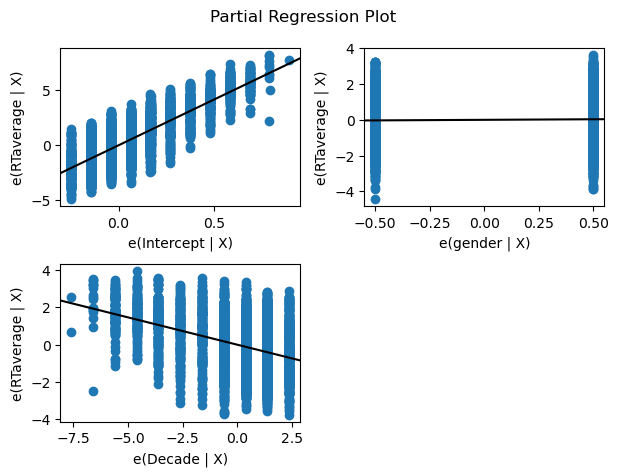

In [14]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [15]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_linear_regression
import numpy as np

In [16]:
# Linear regression with y the logarithm of pageviews and x1 the boolean value of is_after
for i in list(df_matched.Decade.index.value_counts().index):
    mod = smf.ols(formula='TSscore ~ C(gender)', data=df_matched.loc[i])
    res = mod.fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.459
Date:                Sat, 17 Dec 2022   Prob (F-statistic):             0.0196
Time:                        16:54:20   Log-Likelihood:                -5746.8
No. Observations:                1226   AIC:                         1.150e+04
Df Residuals:                    1224   BIC:                         1.151e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         45.3556      1.062     42.

/opt/homebrew/Caskroom/miniforge/base/envs/ADA/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=18

/opt/homebrew/Caskroom/miniforge/base/envs/ADA/lib/python3.10/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/opt/homebrew/Caskroom/miniforge/base/envs/ADA/lib/python3.10/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/opt/homebrew/Caskroom/miniforge/base/envs/ADA/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 2 samples were given.

/opt/homebrew/Caskroom/miniforge/base/e

In [17]:
mod = smf.ols(formula='TSscore ~ C(gender)+year', data=df_matched.loc[[1,2,3,4,5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     62.26
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           9.42e-26
Time:                        16:54:21   Log-Likelihood:                -3423.9
No. Observations:                 758   AIC:                             6854.
Df Residuals:                     755   BIC:                             6868.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1259.0769    106.482     11.

In [18]:
mod = smf.ols(formula='RTaverage ~ C(gender)', data=df_matched.loc[[4,5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.208
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.272
Time:                        16:54:21   Log-Likelihood:                -1069.2
No. Observations:                 630   AIC:                             2142.
Df Residuals:                     628   BIC:                             2151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.6997      0.075     89.

In [19]:
mod = smf.ols(formula='RTaverage ~ C(gender)', data=df_matched.loc[1:6])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.454
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.229
Time:                        16:54:21   Log-Likelihood:                -655.94
No. Observations:                 396   AIC:                             1316.
Df Residuals:                     394   BIC:                             1324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.0035      0.090     77.

# Revenue

In [20]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = df_movie_usa.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
df_movie_usa = merge.drop(columns=['Principal_character_sex'])
df_movie_usa = df_movie_usa[(df_movie_usa.Actor_gender == 'M') | (df_movie_usa.Actor_gender == 'F')]
df_character_usa = pd.read_csv('df_character_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Movie_date'])
df_movie_usa['year'] = df_movie_usa['Movie_date'].apply(lambda x: int(x[0:4]))
df_movie_usa['Movie_revenue'] = df_movie_usa['Movie_revenue'].astype(float)
df_movie_usa = df_movie_usa.dropna(subset=['Movie_revenue'])
df_movie_usa['gender'] = df_movie_usa['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [21]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['year']>=int(decade[0:4])) & (df_movie_usa['year']<int(decade[5:9]))].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]

In [22]:
#create a SPARQL wikidata query to retrieve the rotten tomatoes score review when available
US_rev = '''
SELECT ?film ?reviewLabel ?freebase_ID ?score_byLabel ?methodLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?film wdt:P31 wd:Q11424;      #select all the instances that has the 'film' category
    wdt:P495 wd:Q30;            #select the films that comes from the US
    wdt:P646 ?freebase_ID;      #retrieve the freebase_ID
    p:P444 ?revieww.            #filter the movies that has a review score
    ?revieww ps:P444 ?review;   #display the review score
    pq:P447 ?score_by;          #display the origin of the review
    pq:P459 ?method.            #display the method used by the review (tomatometer score, average score)
}
'''
US_film_rev = wikidata2df(US_rev)  #convert the json file from the query into a pandas dataframe

In [23]:
box = '''
SELECT ?revenueLabel ?freebase_ID ?in
WHERE {
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    ?movie wdt:P31 wd:Q11424;
    wdt:P495 wd:Q30;
    wdt:P646 ?freebase_ID;
    p:P2142 ?revenuee.
    ?revenuee ps:P2142 ?revenue.
}
'''

In [24]:
boxdf = wikidata2df(box)
boxdf

,revenueLabel,freebase_ID
0,7000000,/m/027jhb
1,38275483,/m/048hvr
2,424208848,/m/0y_9q
3,408000000,/m/0jjy0
4,12021272,/m/0gd92
...,...,...
2102,672806292,/m/07j94
2103,27615743,/m/017n9
2104,700426566,/m/0126b7rc
2105,1347597973,/m/0126b7rc


In [25]:
df_movie_usamerged = df_movie_usa.merge(boxdf, left_on='Freebase_movie_ID', right_on='freebase_ID', how='left')
df_movie_usamerged['Movie_revenue'] =  df_movie_usamerged['revenueLabel'].combine_first(df_movie_usamerged['Movie_revenue'])

In [26]:
US_rev = '''
SELECT ?film ?reviewLabel ?freebase_ID ?score_byLabel ?methodLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?film wdt:P31 wd:Q11424;      #select all the instances that has the 'film' category
    wdt:P495 wd:Q30;            #select the films that comes from the US
    wdt:P646 ?freebase_ID;      #retrieve the freebase_ID
    p:P444 ?revieww.            #filter the movies that has a review score
    ?revieww ps:P444 ?review;   #display the review score
    pq:P447 ?score_by;          #display the origin of the review
    pq:P459 ?method.            #display the method used by the review (tomatometer score, average score)
}
'''

In [27]:
wikidata2df(US_rev)

,film,freebase_ID,score_byLabel,methodLabel,reviewLabel
0,Q2404100,/m/0cwmf4,Rotten Tomatoes,Tomatometer score,100%
1,Q2201,/m/05f4_n0,Rotten Tomatoes,Rotten Tomatoes average rating,7.1/10
2,Q128854,/m/0kv9d3,Rotten Tomatoes,Rotten Tomatoes average rating,7.1/10
3,Q129037,/m/03np63f,Rotten Tomatoes,Rotten Tomatoes average rating,7.1/10
4,Q102438,/m/03176f,Rotten Tomatoes,Rotten Tomatoes average rating,7.1/10
...,...,...,...,...,...
24120,Q3282532,/m/07630r,Rotten Tomatoes,Rotten Tomatoes average rating,3.4/10
24121,Q3346204,/m/0g54d4c,Rotten Tomatoes,Rotten Tomatoes average rating,3.4/10
24122,Q3402011,/m/0bcyw8,Rotten Tomatoes,Rotten Tomatoes average rating,3.4/10
24123,Q3566419,/m/05kdryb,Rotten Tomatoes,Rotten Tomatoes average rating,3.4/10


In [170]:
df_matched = pd.DataFrame()
# For loop on the unique index in df4
for i in list(df_movie_group.index.value_counts().index):
    count = df_movie_group.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = df_movie_group.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched = pd.concat([df1,df2,df_matched])                # join the results in df_matched
    

print('The number of actors discarded is : '+ str(len(df_movie_group)-len(df_matched)))
print('The number of matched pairs is : '+ str(int(len(df_matched)/2)))

The number of actors discarded is : 2654
The number of matched pairs is : 1780


In [171]:
df_matched.rename(columns={'TS score_x':'TSscore'}, inplace=True)

In [172]:
df_matched= df_matched.dropna(subset=['Movie_date'])

In [173]:
df_matched['year'] = df_matched['Movie_date'].apply(lambda x: int(x[0:4]))

In [174]:
df_matched['log_revenue'] = np.log(df_matched['Movie_revenue'])

In [175]:
mod = smf.ols(formula='log_revenue ~ gender', data=df_matched.loc[[4]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.1230
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.730
Time:                        17:00:05   Log-Likelihood:                -26.027
No. Observations:                  21   AIC:                             56.05
Df Residuals:                      19   BIC:                             58.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.9890      0.254     59.103      0.0

eval_env: 1
eval_env: 1


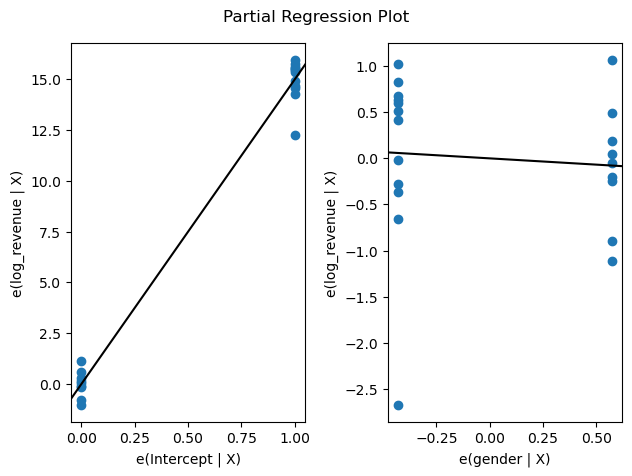

In [176]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [177]:
mod = smf.ols(formula='log_revenue ~ gender', data=df_matched.loc[7])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.548
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.217
Time:                        17:00:06   Log-Likelihood:                -128.63
No. Observations:                  82   AIC:                             261.3
Df Residuals:                      80   BIC:                             266.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.8363      0.175     96.046      0.0

## Log_revenue as a function of gender

In [178]:
df_matched.loc[[1,2,3,4,5]]

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TSscore,...,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_actor,Actor_name,Actor_gender,year,Decade,gender,log_revenue
Decade,,,,,,,,,,,,,,,,,,,,,
1,73380,/m/0jq5p,Broken Blossoms,1919,NaN,75.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Silent film', 'Indie', 'Black-and-white', 'D...",95.0,...,0.0,Cheng,Lucy,Olivia de Havilland,Olivia de Havilland,F,1919,1,0,NaN
1,238484,/m/01jlds,Tillie's Punctured Romance,1914-11-14,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Silent film', 'Indie', 'B...",90.0,...,6.0,Tillie,Chaplin,Chris Bruno,Chris Bruno,M,1914,1,1,NaN
2,76313,/m/0k42n,Safety Last!,1923-04-01,NaN,73.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Silent film', 'Indie', 'Black-an...",97.0,...,0.0,Bill,Harold,Linda Blair,Linda Blair,F,1923,2,0,NaN
2,3566585,/m/09l_6k,The Unknown,1927,NaN,181.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Horror', 'Silent film', 'Drama', 'Indie', 'B...",100.0,...,9.0,Nanon,Antonio,Joan Crawford,Joan Crawford,F,1927,2,0,NaN
2,1216093,/m/04j1yl,The Cocoanuts,1929-05-03,NaN,93.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Absurdism', 'Screwball comedy', 'Black-and-w...",95.0,...,1.0,Mrs.,Potter,Annette Bening,Annette Bening,F,1929,2,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,961796,/m/03tp6l,House of Wax,1953-04-25,NaN,90.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],['Horror'],95.0,...,1.0,Jarrod,Burke,Vincent Price,Vincent Price,M,1953,5,1,NaN
5,1591865,/m/05d_s8,Broken Lance,1954,3800000.0,96.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Action/Adventure', 'Western', 'Family Drama'...",92.0,...,0.0,Matt,Joe,Spencer Tracy,Spencer Tracy,M,1954,5,1,15.150512
5,6759112,/m/0gmhr_,Rock-A-Bye Baby,1958,NaN,103.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Musical', 'Comedy']",63.0,...,4.0,Carla,Clayton,Ben Stiller,Ben Stiller,M,1958,5,1,NaN


In [179]:
mod = smf.ols(formula='log_revenue ~ gender+year', data=df_matched.loc[[1,2,3,4,5,6]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     42.37
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           2.92e-16
Time:                        17:00:07   Log-Likelihood:                -329.43
No. Observations:                 220   AIC:                             664.9
Df Residuals:                     217   BIC:                             675.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -110.2374     13.738     -8.024      0.0

In [180]:
mod = smf.ols(formula='log_revenue ~ gender', data=df_matched.loc[[6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.171
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.281
Time:                        17:00:08   Log-Likelihood:                -222.96
No. Observations:                 139   AIC:                             449.9
Df Residuals:                     137   BIC:                             455.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.7303      0.139    120.328      0.0

## TSscore as a function of gender

In [181]:
mod = smf.ols(formula='TSscore ~ gender', data=df_matched.loc[[1,2,3,4,5,6]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.288
Date:                Sat, 17 Dec 2022   Prob (F-statistic):             0.0218
Time:                        17:00:09   Log-Likelihood:                -2510.4
No. Observations:                 566   AIC:                             5025.
Df Residuals:                     564   BIC:                             5033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     79.2155      1.216     65.154      0.0

In [182]:
mod = smf.ols(formula='TSscore ~ gender', data=df_matched.loc[[6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.149
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.144
Time:                        17:00:10   Log-Likelihood:                -1583.7
No. Observations:                 342   AIC:                             3171.
Df Residuals:                     340   BIC:                             3179.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     67.1228      1.904     35.253      0.0

## RTaverage as a function of gender

In [183]:
mod = smf.ols(formula='RTaverage ~ gender', data=df_matched.loc[[4,5]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.919
Date:                Sat, 17 Dec 2022   Prob (F-statistic):             0.0886
Time:                        17:00:11   Log-Likelihood:                -436.96
No. Observations:                 288   AIC:                             877.9
Df Residuals:                     286   BIC:                             885.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0167      0.092     76.052      0.0

In [184]:
mod = smf.ols(formula='RTaverage ~ gender', data=df_matched.loc[[6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.753
Date:                Sat, 17 Dec 2022   Prob (F-statistic):             0.0980
Time:                        17:00:12   Log-Likelihood:                -589.99
No. Observations:                 342   AIC:                             1184.
Df Residuals:                     340   BIC:                             1192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4327      0.104     61.753      0.0

## Men/Women count in characters dataset

In [47]:
[list(df_character_usa.Actor_name.value_counts().index)]

[['Mel Blanc',
  'Oliver Hardy',
  'Moe Howard',
  'Larry Fine',
  'Harold Lloyd',
  'John Wayne',
  'Frank Welker',
  'Stan Laurel',
  'Roscoe Arbuckle',
  'Harry Carey',
  'Lon Chaney, Sr.',
  'Curly Howard',
  'Mickey Rooney',
  'William Garwood',
  'Samuel L. Jackson',
  'Leslie Nielsen',
  'John Carradine',
  'Hoot Gibson',
  'Bette Davis',
  'Jim Cummings',
  'Samuel Howard',
  'Mae Questel',
  'Christopher Walken',
  'Harry von Meter',
  'Glenn Ford',
  'Roy Rogers',
  'Charlie Chaplin',
  'Gary Cooper',
  'Buster Keaton',
  'Robert Duvall',
  'Boris Karloff',
  'Anthony Quinn',
  'Charlotte Burton',
  'Wallace Beery',
  'Dennis Hopper',
  'Lionel Barrymore',
  'John Goodman',
  'Huntz Hall',
  'Joan Crawford',
  'Robert Mitchum',
  'Burt Reynolds',
  'Vernon Dent',
  'Robert De Niro',
  'Rip Torn',
  'Steve Buscemi',
  'James Stewart',
  'Claudette Colbert',
  'Henry Fonda',
  'James Earl Jones',
  'Charles Durning',
  'Bruce Willis',
  'Eric Roberts',
  'Keenan Wynn',
  'Susan

In [48]:
df_character_usa_M = df_character_usa[df_character_usa.Actor_gender == 'M']
df_character_usa_F = df_character_usa[df_character_usa.Actor_gender == 'F']

In [49]:
count = df_character_usa.Actor_gender.value_counts()
count

M    152713
F     73456
Name: Actor_gender, dtype: int64

In [50]:
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_actor,Actor_name,Actor_gender,year,gender,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,1.0,0.0,Ballard,Williams,Natasha Henstridge,Natasha Henstridge,F,2001,0,10
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",NaN,...,12.0,7.0,Mary,Banks,Julie Andrews,Julie Andrews,F,1964,0,6
2,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",71%,...,11.0,4.0,Jody,Yvette,Tyrese Gibson,Tyrese Gibson,M,2001,1,10
4,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Action/Adventure', 'Action'...",0%,...,2.0,2.0,Crowe,NaN,Peggy Lipton,Peggy Lipton,F,1989,0,8
5,5708633,/m/0f0d1p,The Great New Wonderful,2006-06-23,172055.0,87.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Ensemble Film', 'Comedy-drama', 'In...",NaN,...,0.0,1.0,Judy,Greer,Peggy Lipton,Peggy Lipton,F,2006,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12430,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Action/Adventure', 'Disaster']",61%,...,2.0,0.0,Jo,Bill,Cary Elwes,Cary Elwes,M,1996,1,9
12431,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","['France', 'United States of America']","['Thriller', 'Science Fiction', 'Action/Advent...",92%,...,11.0,4.0,Stevens,Goodwin,Jake Gyllenhaal,Jake Gyllenhaal,M,2011,1,11
12435,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Comedy of manners', 'Dram...",72%,...,10.0,0.0,Akeem,Lisa,Eddie Murphy,Eddie Murphy,M,1988,1,8
12437,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,1.0,1.0,Carla,Walt,Julia Stiles,Julia Stiles,F,2000,0,10


In [51]:
df_movie_usa['Male_count'] = df_movie_usa['gender']

In [52]:
df_movie_usa['Male_count'] = df_movie_usa['Male_count'].replace({0:1, 1:0})

In [53]:
df_movie_usa = df_movie_usa.rename(columns={'gender':'male_count','Male_count':'female_count'})

In [54]:
df_movie_usa['count'] = 1

In [55]:
group = df_movie_usa.groupby('Decade').sum()
group

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_53358/3790238580.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Wikipedia_movie_ID,Movie_revenue,Movie_runtime,feminine,sexist,sexiest,beauty,beautiful,positive_emotion,negative_emotion,Number_of_words,he_count,she_count,year,male_count,female_count,count
Decade,,,,,,,,,,,,,,,,,
1,3333,5.000000e+07,190.0,1.0,0.0,0.0,1.0,0.0,4.0,8.0,997.0,8.0,7.0,1915,0,1,1
2,67735792,2.163100e+07,878.0,12.0,0.0,0.0,1.0,0.0,35.0,19.0,3988.0,37.0,17.0,17340,4,5,9
3,401081022,9.379765e+08,6384.0,68.0,0.0,0.0,18.0,0.0,197.0,212.0,29537.0,288.0,234.0,129660,36,31,67
4,386286855,6.408725e+08,6711.0,55.0,0.0,0.0,24.0,0.0,180.0,242.0,29040.0,322.0,157.0,126381,49,16,65
5,3369588926,1.954511e+09,39263.0,436.0,0.0,0.0,115.0,0.0,856.0,1320.0,167739.0,1738.0,878.0,744424,275,106,381
6,574517570,3.803542e+09,14864.0,161.0,0.0,0.0,49.0,0.0,314.0,551.0,75896.0,645.0,399.0,233874,82,37,119
7,799569988,1.115284e+10,24502.0,277.0,0.0,0.0,63.0,0.0,478.0,1068.0,133613.0,1077.0,463.0,428638,159,58,217
8,3379091135,2.788360e+10,78608.0,793.0,0.0,0.0,243.0,0.0,1803.0,3276.0,417948.0,3510.0,1758.0,1491082,555,196,751
9,4371677234,8.148924e+10,133837.0,1412.0,0.0,0.0,407.0,0.0,3461.0,6358.0,775793.0,7651.0,3335.0,2463761,894,341,1235


<AxesSubplot:xlabel='Decade', ylabel='count'>

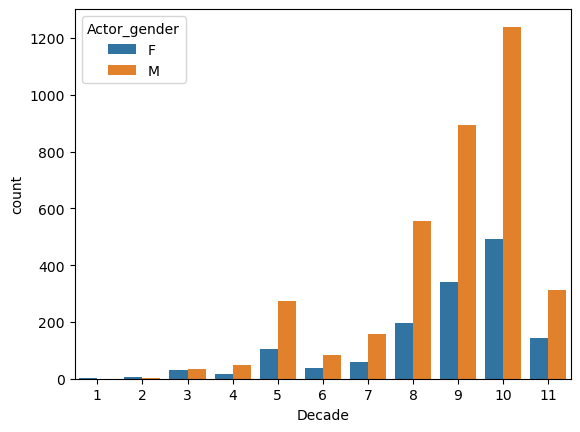

In [56]:
sns.barplot(x=df_movie_usa.Decade, y=df_movie_usa['count'], hue=df_movie_usa.Actor_gender, estimator=sum)

<AxesSubplot:>

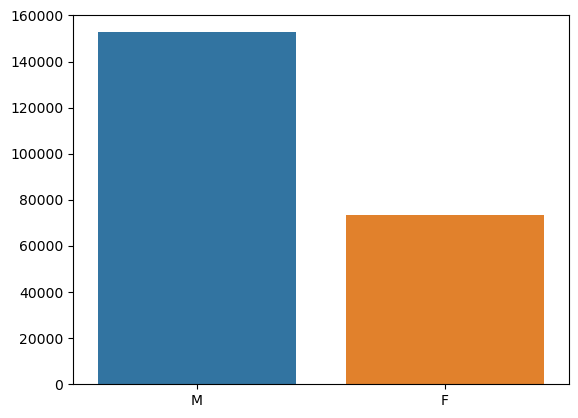

In [57]:
sns.barplot(x=count.index, y=count.values)

In [58]:
df_movie = pd.read_table(data_folder +'movie.metadata.tsv',header=None)
df_movie.columns=['Wikipedia_movie_ID' , 'Freebase_movie_ID', 'Movie_name' , 'Movie_date' , 'Movie_revenue' , 'Movie_runtime' , 'Movie_languages' , 'Movie_countries' , 'Movie_genres']
genres = df_movie['Movie_genres']
genres =  genres.apply(lambda x: x.replace('{','').replace('}','')) 

In [59]:
genres = genres.str.split(',')

In [60]:
genres_list = genres.explode().value_counts()
genres_list

 "/m/07s9rl0": "Drama"             22491
 "/m/01z4y": "Comedy"              13586
"/m/07s9rl0": "Drama"              11516
 "/m/01g6gs": "Black-and-white"     8162
"/m/02hmvc": "Short Film"           7598
                                   ...  
"/m/05bdtfl": "Period Horror"          1
"/m/0hj3mx7": "Business"               1
"/m/094ddt": "Doomsday film"           1
 "/m/0c031k6": "Live action"           1
 "/m/05453r": "Homoeroticism"          1
Name: Movie_genres, Length: 654, dtype: int64

In [61]:
query = '''
SELECT ?movie ?genreLabel ?freebase_id
WHERE
{ SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?movie wdt:P31 wd:Q11424.  # ?movie is an instance of Q11424 (film)
  ?movie wdt:P495 wd:Q30.  # ?movie is produced in the US
  ?movie wdt:P136 ?genre.  # ?movie has a genre of ?genre
  ?movie wdt:P646 ?freebase_id.  # ?movie has a Freebase ID of ?freebase_id
}
'''

In [62]:
genrewiki = wikidata2df(query)
genrewiki = genrewiki.drop_duplicates('freebase_id')

In [63]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')

In [64]:
genrewiki.genreLabel.value_counts()

drama film          12268
comedy film          4334
documentary film     3097
horror film          2154
Western film         1994
                    ...  
film adaptation         1
hard rock               1
Bruceploitation         1
play                    1
humour                  1
Name: genreLabel, Length: 205, dtype: int64

In [65]:
new = df_movie_usa.merge(genrewiki, left_on='Freebase_movie_ID', right_on='freebase_id',how='left')

In [66]:
new

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor,genreLabel,freebase_id,movie
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,396.0,1.0,0.0,Ballard,Williams,F,Natasha Henstridge,action film,/m/03vyhn,Q261700
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,drama film,/m/02qc0j7,Q1619977
4,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,drama film,/m/017n1p,Q1579725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,252.0,1.0,1.0,Carla,Walt,F,Julia Stiles,drama film,/m/0660qx,Q960668
34404,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},['United States of America'],"['Thriller', 'Erotic thriller', 'Psychological...",38%,...,611.0,6.0,8.0,Greenhill,Haines,M,Don Johnson,erotic film,/m/030xw6,Q387868
34405,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Comedy film', 'Romance Film', 'Musical']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,comedy film,/m/07k5mlk,Q7769294
34406,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],['Drama'],NaN,...,118.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
new = new.dropna(subset=['genreLabel'])

In [68]:
new = new.dropna(subset=['Movie_date'])

In [69]:
new['year'] = new['Movie_date'].apply(lambda x: int(x[0:4]))

In [70]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
new['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = new[ (new['year']>=int(decade[0:4])) & (new['year']<int(decade[5:9]))].index
    new.loc[index1,'Decade'] = decades_code[ctr]

In [71]:
new

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor,genreLabel,freebase_id,movie,year,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,0.0,Ballard,Williams,F,Natasha Henstridge,action film,/m/03vyhn,Q261700,2001,10
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",80%,...,NaN,NaN,NaN,NaN,NaN,drama film,/m/02qc0j7,Q1619977,1938,3
4,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,drama film,/m/017n1p,Q1579725,1930,3
5,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Ensemble Film', 'Comedy-d...",NaN,...,5.0,Adam,Kate,NaN,NaN,romantic comedy,/m/0gffwj,Q6649585,1997,9
9,175024,/m/017n1b,The Devil's Holiday,1930,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romance Film', 'Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,drama film,/m/017n1b,Q729807,1930,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34402,26044505,/m/0b6m67n,The Flying Serpent,1946,NaN,59.0,{},['United States of America'],"['Thriller', 'B-movie', 'Horror']",NaN,...,0.0,Andrew,Forbes,NaN,NaN,horror film,/m/0b6m67n,Q7734623,1946,4
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,1.0,Carla,Walt,F,Julia Stiles,drama film,/m/0660qx,Q960668,2000,10
34404,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},['United States of America'],"['Thriller', 'Erotic thriller', 'Psychological...",38%,...,8.0,Greenhill,Haines,M,Don Johnson,erotic film,/m/030xw6,Q387868,1993,9
34405,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Comedy film', 'Romance Film', 'Musical']",NaN,...,NaN,NaN,NaN,NaN,NaN,comedy film,/m/07k5mlk,Q7769294,1946,4


In [72]:
new = new.groupby(['Decade','genreLabel'],group_keys=True).apply(lambda x:x)
new.index = new.index.droplevel(2)

In [73]:
new.genreLabel.value_counts()

drama film              8113
comedy film             2848
documentary film        1714
horror film             1452
action film             1202
                        ... 
romantic thriller          1
satire                     1
female buddy film          1
stoner film                1
psychological horror       1
Name: genreLabel, Length: 167, dtype: int64

In [74]:
new = new[(new.genreLabel=='drama film') | (new.genreLabel=='comedy film') | (new.genreLabel=='documentary film') | (new.genreLabel=='horror film') | (new.genreLabel=='action film')]

In [75]:
new['count'] = 1

In [76]:
new = new.dropna(subset=['Principal_character_actor'])

<AxesSubplot:xlabel='Decade', ylabel='count'>

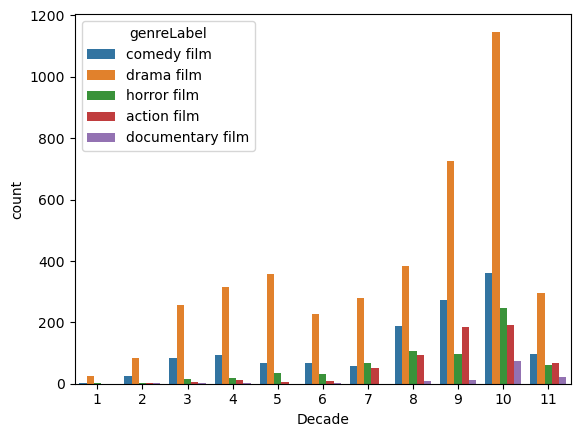

In [77]:
sns.barplot(x=new.Decade, y=new['count'], hue = new.genreLabel, estimator=sum)

## Drama film

In [78]:
drama = new[new.genreLabel=='drama film']

In [79]:
drama = drama.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = drama.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
drama = merge.drop(columns=['Principal_character_sex'])
drama = drama[(drama.Actor_gender == 'M') | (drama.Actor_gender == 'F')]

In [80]:
drama.Actor_gender.value_counts()

M    2803
F    1275
Name: Actor_gender, dtype: int64

In [81]:
drama['gender'] = drama['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [82]:
drama = drama.groupby(['Decade'],group_keys=True).apply(lambda x:x)

In [83]:
drama.index = drama.index.droplevel(1)

In [84]:
list(drama.index.value_counts().index)

[10, 9, 8, 5, 4, 11, 7, 3, 6, 2, 1]

In [85]:
drama.loc[10]['gender'].value_counts()

1    784
0    359
Name: gender, dtype: int64

In [86]:
len(drama.loc[10]['gender'].value_counts())

2

In [87]:
drama.loc[10]['gender'].value_counts().min()

359

In [88]:
df_matched_drama = pd.DataFrame()
# For loop on the unique index in df4
for i in list(drama.index.value_counts().index):
    count = drama.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = drama.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched_drama = pd.concat([df1,df2,df_matched_drama])                # join the results in df_matched
    

print('The number of actors discarded is : '+ str(len(drama)-len(df_matched_drama)))
print('The number of matched pairs is : '+ str(int(len(df_matched_drama)/2)))

The number of actors discarded is : 1528
The number of matched pairs is : 1275


In [89]:
df_matched_drama['TS score_x'] = df_matched_drama['TS score_x'].str.replace("\%", "", regex=True)
df_matched_drama['RT average_x'] = df_matched_drama['RT average_x'].str.split('/').str[0].astype(float)
df_matched_drama['TS score_x'] = df_matched_drama['TS score_x'].astype(float)
df_matched_drama.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [90]:
df_matched_drama = df_matched_drama.dropna(subset=['Movie_date'])

In [91]:
df_matched_drama['year'] = df_matched_drama['Movie_date'].apply(lambda x: int(x[0:4]))

In [141]:
mod = smf.ols(formula = 'TSscore ~ gender+Decade', data = df_matched_drama.loc[[4,5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     19.40
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           9.89e-09
Time:                        16:56:23   Log-Likelihood:                -1657.5
No. Observations:                 368   AIC:                             3321.
Df Residuals:                     365   BIC:                             3333.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    104.9335      5.905     17.770      0.0

eval_env: 1
eval_env: 1
eval_env: 1


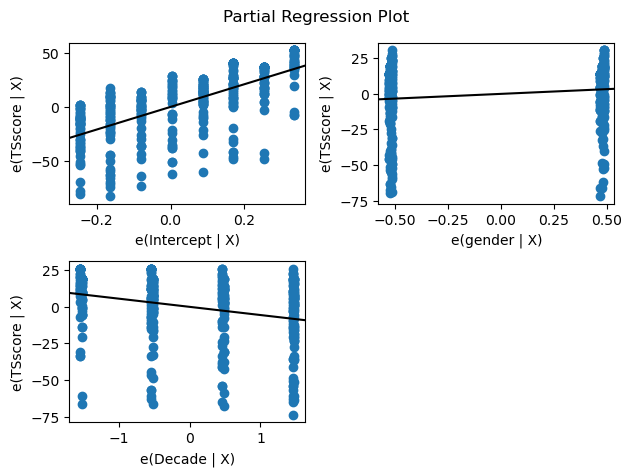

In [142]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [143]:
mod = smf.ols(formula = 'TSscore ~ gender+Decade', data = df_matched_drama.loc[[8,9,10,11]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     23.67
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           7.78e-11
Time:                        16:56:32   Log-Likelihood:                -6427.5
No. Observations:                1381   AIC:                         1.286e+04
Df Residuals:                    1378   BIC:                         1.288e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    103.1337      7.484     13.781      0.0

eval_env: 1
eval_env: 1
eval_env: 1


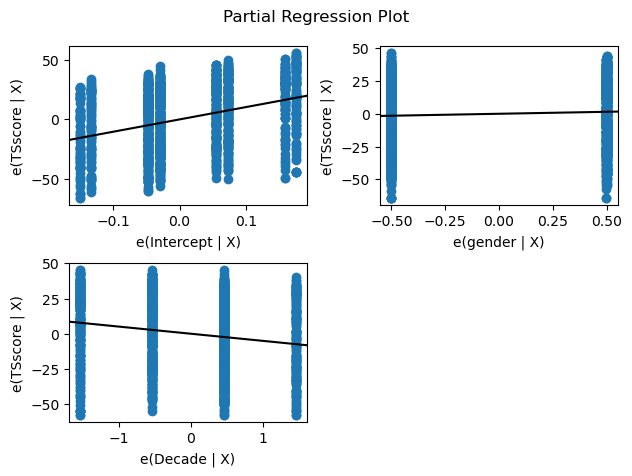

In [144]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [145]:
mod = smf.ols(formula = 'RTaverage ~ gender+Decade', data = df_matched_drama.loc[[4,5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     11.91
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           9.76e-06
Time:                        16:56:38   Log-Likelihood:                -601.39
No. Observations:                 367   AIC:                             1209.
Df Residuals:                     364   BIC:                             1221.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0658      0.337     23.954      0.0

eval_env: 1
eval_env: 1
eval_env: 1


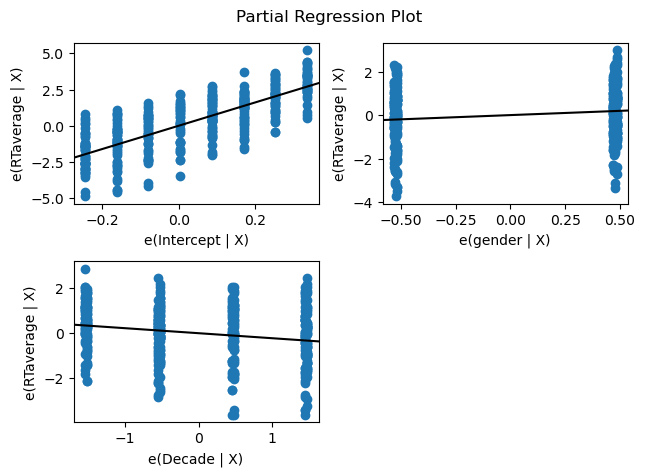

In [146]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [147]:
mod = smf.ols(formula = 'RTaverage ~ gender+Decade', data = df_matched_drama.loc[[8,9,10,11]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     20.54
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.62e-09
Time:                        16:56:42   Log-Likelihood:                -2285.3
No. Observations:                1381   AIC:                             4577.
Df Residuals:                    1378   BIC:                             4592.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9780      0.373     21.399      0.0

eval_env: 1
eval_env: 1
eval_env: 1


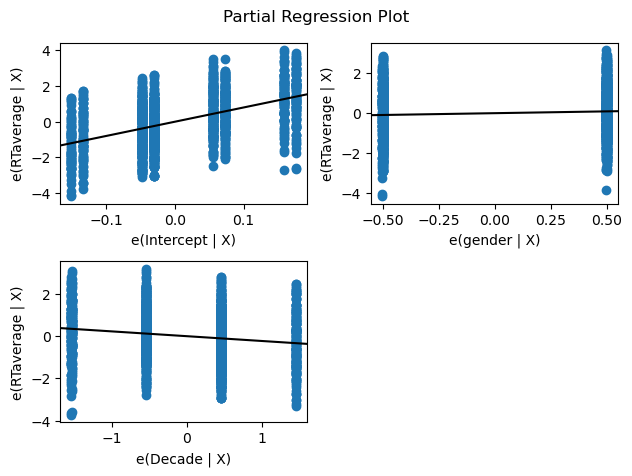

In [148]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

## Comedy film

In [149]:
comedy = new[new.genreLabel=='comedy film']

In [150]:
comedy = comedy.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = comedy.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
comedy = merge.drop(columns=['Principal_character_sex'])
comedy = comedy[(comedy.Actor_gender == 'M') | (comedy.Actor_gender == 'F')]

In [151]:
comedy.Actor_gender.value_counts()

M    987
F    326
Name: Actor_gender, dtype: int64

In [152]:
comedy['gender'] = comedy['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [153]:
comedy = comedy.groupby(['Decade'],group_keys=True).apply(lambda x:x)

In [154]:
comedy.index = comedy.index.droplevel(1)

In [155]:
df_matched_comedy = pd.DataFrame()
# For loop on the unique index in df4
for i in list(comedy.index.value_counts().index):
    count = comedy.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = comedy.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched_comedy = pd.concat([df1,df2,df_matched_comedy])                # join the results in df_matched
    

print('The number of actor discarded is : '+ str(len(comedy)-len(df_matched_comedy)))
print('The number of matched pairs is : '+ str(int(len(df_matched_comedy)/2)))

The number of actor discarded is : 661
The number of matched pairs is : 326


In [156]:
df_matched_comedy['TS score_x'] = df_matched_comedy['TS score_x'].str.replace("\%", "", regex=True)
df_matched_comedy['RT average_x'] = df_matched_comedy['RT average_x'].str.split('/').str[0].astype(float)
df_matched_comedy['TS score_x'] = df_matched_comedy['TS score_x'].astype(float)
df_matched_comedy.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [157]:
df_matched_comedy = df_matched_comedy.dropna(subset=['Movie_date'])

In [158]:
df_matched_comedy['year'] = df_matched_comedy['Movie_date'].apply(lambda x: int(x[0:4]))

In [159]:
mod = smf.ols(formula = 'RTaverage ~ gender+Decade', data = df_matched_comedy.loc[[4,5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.6828
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.509
Time:                        16:56:57   Log-Likelihood:                -84.031
No. Observations:                  60   AIC:                             174.1
Df Residuals:                      57   BIC:                             180.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1206      0.711     10.012      0.0

eval_env: 1
eval_env: 1
eval_env: 1


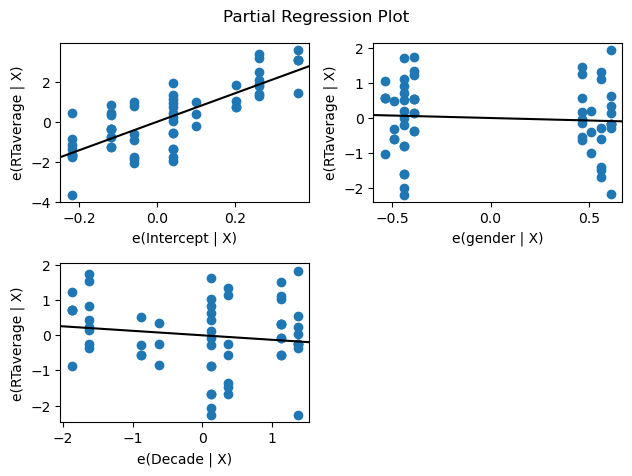

In [160]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [161]:
mod = smf.ols(formula = 'RTaverage ~ gender+Decade', data = df_matched_comedy.loc[[8,9,10,11]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3571
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.700
Time:                        16:57:00   Log-Likelihood:                -514.84
No. Observations:                 304   AIC:                             1036.
Df Residuals:                     301   BIC:                             1047.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2873      0.755      7.005      0.0

eval_env: 1
eval_env: 1
eval_env: 1


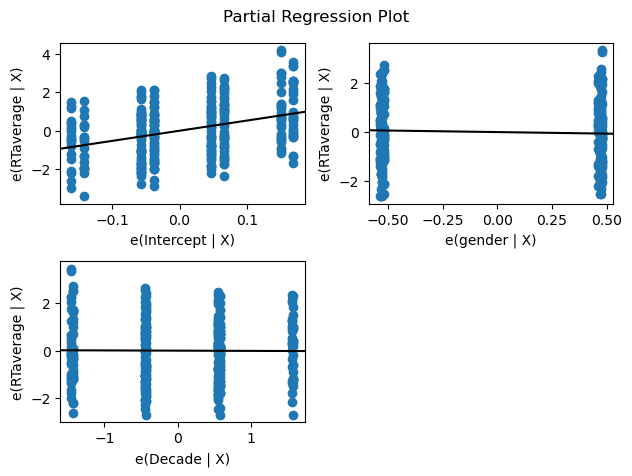

In [162]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

## Action film

In [109]:
action = new[new.genreLabel=='action film']

In [110]:
action = action.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = action.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
action = merge.drop(columns=['Principal_character_sex'])
action = action[(action.Actor_gender == 'M') | (action.Actor_gender == 'F')]

In [111]:
action.Actor_gender.value_counts()

M    489
F    129
Name: Actor_gender, dtype: int64

In [112]:
action['gender'] = action['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [113]:
action = action.groupby(['Decade'],group_keys=True).apply(lambda x:x)

In [114]:
action.index = action.index.droplevel(1)

In [115]:
df_matched_action = pd.DataFrame()
# For loop on the unique index in df4
for i in list(action.index.value_counts().index):
    count = action.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = action.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched_action = pd.concat([df1,df2,df_matched_action])                # join the results in df_matched
    

print('The number of athletes discarded is : '+ str(len(action)-len(df_matched_action)))
print('The number of matched pairs is : '+ str(int(len(df_matched_action)/2)))

The number of athletes discarded is : 360
The number of matched pairs is : 129


In [116]:
df_matched_action['TS score_x'] = df_matched_action['TS score_x'].str.replace("\%", "", regex=True)
df_matched_action['RT average_x'] = df_matched_action['RT average_x'].str.split('/').str[0].astype(float)
df_matched_action['TS score_x'] = df_matched_action['TS score_x'].astype(float)
df_matched_action.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [117]:
df_matched_action= df_matched_action.dropna(subset=['Movie_date'])

In [118]:
df_matched_action['year'] = df_matched_action['Movie_date'].apply(lambda x: int(x[0:4]))

In [119]:
mod = smf.ols(formula = 'RTaverage ~ gender', data = df_matched_action.loc[[7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.554
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.244
Time:                        16:55:16   Log-Likelihood:                -15.927
No. Observations:                  11   AIC:                             35.85
Df Residuals:                       9   BIC:                             36.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3143      0.430     14.680      0.0

/opt/homebrew/Caskroom/miniforge/base/envs/ADA/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=11



In [120]:
mod = smf.ols(formula = 'RTaverage ~ gender', data = df_matched_action.loc[[8,9,10,11]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.744
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.189
Time:                        16:55:16   Log-Likelihood:                -278.65
No. Observations:                 162   AIC:                             561.3
Df Residuals:                     160   BIC:                             567.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0800      0.152     33.414      0.0

In [121]:
df_movie = pd.read_table(data_folder +'movie.metadata.tsv',header=None)
df_movie.columns=['Wikipedia_movie_ID' , 'Freebase_movie_ID', 'Movie_name' , 'Movie_date' , 'Movie_revenue' , 'Movie_runtime' , 'Movie_languages' , 'Movie_countries' , 'Movie_genres']
df_movie['Movie_countries'] = df_movie['Movie_countries'].apply( lambda x: list(eval(x).values())) #display countries as a list of country names
df_movie['Movie_genres'] = df_movie['Movie_genres'].apply( lambda x: list(eval(x).values()) ) #display genres as a list of genre name
df_movie

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}",[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}",[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


In [122]:
df_movie = df_movie.dropna(subset=['Movie_date'])

In [123]:
df_movie['year'] = df_movie['Movie_date'].apply(lambda x: int(x[0:4]))

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_53358/4200689353.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [124]:
count = df_movie.year.value_counts()

In [125]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_movie['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie[ (df_movie['year']>=int(decade[0:4])) & (df_movie['year']<int(decade[5:9]))].index
    df_movie.loc[index1,'Decade'] = decades_code[ctr]

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_53358/651138768.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [126]:
df_movie['Movie_date']

0        2001-08-24
1        2000-02-16
2              1988
3              1987
4              1983
            ...    
81736    2011-03-19
81737    2011-01-21
81738    1972-09-22
81739    1992-05-21
81740          2002
Name: Movie_date, Length: 74839, dtype: object

In [127]:
df_movie

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,year,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,10
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,10
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}",[Norway],"[Crime Fiction, Drama]",1988,8
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,8
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama],1983,8
...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],[Drama],2011,11
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011,11
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Satire, Comedy]",1972,7
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}",[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992,9


In [128]:
df_movie.Decade.value_counts().sort_values()

0       345
1      2669
2      2883
4      4466
3      4800
11     5228
5      5723
6      5875
7      6716
8      7397
9      9469
10    19268
Name: Decade, dtype: int64

<AxesSubplot:>

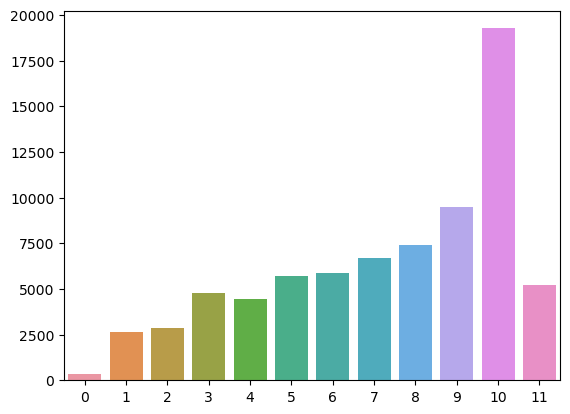

In [129]:
sns.barplot(x=df_movie.Decade.value_counts().sort_values().index, y=df_movie.Decade.value_counts().sort_values().values)

In [130]:
df_character = pd.read_table(data_folder +'character.metadata.tsv',header=None)
df_character.columns=['Wikipedia_movie_ID' , 'Freebase_movie_ID' , 'Movie_date' , 'Character_name' , 'Actor_date_of_birth' , 'Actor_gender' , 'Actor_height' , 'Actor_ethnicity' , 'Actor_name' , 'Actor_age_at_movie_release' , 'Freebase_character_actor_ID' , 'Freebase_character_ID' , 'Freebase_actor_ID'  ]


In [131]:
df_character

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [132]:
df_character = df_character.dropna(subset=['Movie_date'])

In [133]:
df_character['year'] = df_character['Movie_date'].apply(lambda x: int(x[0:4]))

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_53358/231183615.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [134]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_character['Decade'] = 0
df_character['Decadetext'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_character[ (df_character['year']>=int(decade[0:4])) & (df_character['year']<int(decade[5:9]))].index
    df_character.loc[index1,'Decade'] = decades_code[ctr]
    df_character.loc[index1,'Decadetext'] = decades[ctr]
    

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_53358/625579320.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_53358/625579320.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



SyntaxError: incomplete input (3424476744.py, line 1)

In [136]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Movie_date'])
df_movie_usa['year'] = df_movie_usa['Movie_date'].apply(lambda x: int(x[0:4]))
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['year']>=int(decade[0:4])) & (df_movie_usa['year']<int(decade[5:9]))].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]

In [137]:
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,negative_emotion,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor,year,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,7.0,396.0,1.0,0.0,Ballard,Williams,F,Natasha Henstridge,2001,10
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,10
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1913,1
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1938,3
4,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1930,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,1.0,252.0,1.0,1.0,Carla,Walt,F,Julia Stiles,2000,10
34404,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},['United States of America'],"['Thriller', 'Erotic thriller', 'Psychological...",38%,...,9.0,611.0,6.0,8.0,Greenhill,Haines,M,Don Johnson,1993,9
34405,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Comedy film', 'Romance Film', 'Musical']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1946,4
34406,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],['Drama'],NaN,...,0.0,118.0,0.0,0.0,NaN,NaN,NaN,NaN,2011,11


<AxesSubplot:>

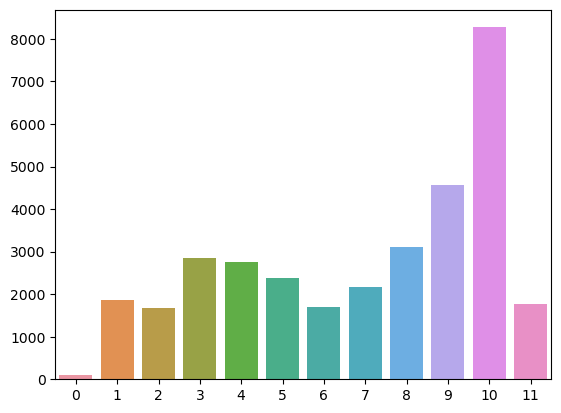

In [138]:
sns.barplot(x=df_movie_usa.Decade.value_counts().sort_values().index, y=df_movie_usa.Decade.value_counts().sort_values().values)